## Access this Notebook
You can launch this notebook in the US GHG Center JupyterHub by clicking the link below. If you are a new user, you should first sign up for the hub by filling out this [**request form**](https://docs.google.com/forms/d/e/1FAIpQLSdai8otCdrVQzJgev8mjDhzKyCg7jcrB3UeTXNHoCiaMKrkaQ/viewform) and providing the required information. 


Access the [**OCO-2 MIP Top-down CO2 Budgets**](https://us-ghg-center.github.io/ghgc-docs/user_data_notebooks/oco2-mip-co2budget-yeargrid-v1_User_Notebook.html) notebook in the US GHG Center JupyterHub. 

## Table of Contents
- [Data Summary and Application](#data-summary-and-application)
- [Approach](#approach)
- [About the Data](#about-the-data)
- [Install the Required Libraries](#install-the-required-libraries)
- [Query the STAC API](#query-the-stac-api)
- [Visual Comparison Across Time Periods](#visual-comparison-across-time-periods)
- [Map Out Selected Tiles](#map-out-selected-tiles)
- [Calculate Zonal Statistics](#calculate-zonal-statistics)
- [Time-Series Analysis](#time-series-analysis)
- [Summary](#summary)

## Data Summary and Application
- **Spatial coverage**: Global
- **Spatial resolution**: 1° x 1°
- **Temporal extent**: 2015 – 2020
- **Temporal resolution**: Annual
- **Unit**: Grams of carbon dioxide per square meter per year
- **Utility**: Climate Research

For more, visit the [OCO-2 MIP Top-down CO2 Budgets](https://earth.gov/ghgcenter/data-catalog/oco2-mip-co2budget-yeargrid-v1) data overview page.  

## About the Data
### OCO-2 MIP Top-Down CO₂ Budgets 

The Committee on Earth Observation Satellites (CEOS) Atmospheric Composition - Virtual Constellation (AC-VC) Greenhouse Gas (GHG) team has generated the CEOS CO₂ Budgets dataset, which provides annual top-down carbon dioxide (CO2) emissions and removals from 2015 - 2020 gridded globally at 1° resolution, and as national totals. Data is provided in units of grams of carbon dioxide per square meter per year (g CO2/m2/yr). Only a subset of the full dataset is displayed in the GHG Center explore view. 

For more information regarding this dataset, please visit the [OCO-2 MIP Top-Down CO₂ Budgets](https://earth.gov/ghgcenter/data-catalog/oco2-mip-co2budget-yeargrid-v1) data overview page.

## Approach

1. Identify available dates and temporal frequency of observations for the given collection using the GHGC API `/stac` endpoint. The collection processed in this notebook is the OCO-2 MIP Top-Down CO₂ Budgets data product.
2. Pass the STAC item into the raster API `/collections/{collection_id}/items/{item_id}/tilejson.json` endpoint.
3. Using `folium.plugins.DualMap`, we will visualize two tiles (side-by-side), allowing us to compare time points. 
4. After the visualization, we will perform zonal statistics for a given polygon.

## Terminology
Navigating data via the GHGC API, you will encounter terminology that is different from browsing in a typical filesystem. We'll define some terms here which are used throughout this notebook.
- `catalog`:    All datasets available at the `/stac` endpoint
- `collection`: A specific dataset, e.g. OCO-2 MIP Top-Down CO2 Budgets
- `item`:       One granule in the dataset, e.g. one year of CO2 fluxes
- `asset`:      A variable available within the granule, e.g. CO2 fluxes from crops, wood, or rivers
- `STAC API`:   **Sp**atio**T**emporal **A**sset **C**atalogs - Endpoint for fetching metadata about available datasets
- `Raster API`: Endpoint for fetching data itself, for imagery and statistics

# Install the Required Libraries
Required libraries are pre-installed on the GHG Center Hub. If you need to run this notebook elsewhere, please install them with this line in a code cell:

%pip install requests folium rasterstats pystac_client pandas matplotlib --quiet

In [1]:
# Import the following libraries
# For fetching from the Raster API
import requests
# For making maps
import folium
import folium.plugins
from folium import Map, TileLayer
# For talking to the STAC API
from pystac_client import Client
# For working with data
import pandas as pd
# For making time series
import matplotlib.pyplot as plt
# For formatting date/time data
import datetime
# Custom functions for working with GHGC data via the API
import ghgc_utils

## Query the STAC API
### STAC API Collection Names

Now, you must fetch the dataset from the [**STAC API**](https://earth.gov/ghgcenter/api/stac/) by defining its associated STAC API collection ID as a variable. 
The collection ID, also known as the **collection name**, for the OCO-2 MIP Top-Down CO<sub>2</sub> Budgets dataset is [**oco2-mip-co2budget-yeargrid-v1**](https://earth.gov/ghgcenter/api/stac/collections/oco2-mip-co2budget-yeargrid-v1).*

**You can find the collection name of any dataset on the GHGC data portal by navigating to the dataset landing page within the data catalog. The collection name is the last portion of the dataset landing page's URL, and is also listed in the pop-up box after clicking "ACCESS DATA."*

In [2]:
# Provide the STAC and RASTER API endpoints
# The endpoint is referring to a location within the API that executes a request on a data collection nesting on the server.

# The STAC API is a catalog of all the existing data collections that are stored in the GHG Center.
STAC_API_URL = "https://earth.gov/ghgcenter/api/stac"

# The RASTER API is used to fetch collections for visualization
RASTER_API_URL = "https://earth.gov/ghgcenter/api/raster"

# Define the collection name, used to fetch the dataset from the STAC API
collection_name = "oco2-mip-co2budget-yeargrid-v1"

In [3]:
# Using PySTAC client
# Fetch the collection from the STAC API using the appropriate endpoint
# The 'pystac' library allows a HTTP request possible
catalog = Client.open(STAC_API_URL)
collection = catalog.get_collection(collection_name)

# Print the properties of the collection to the console
collection

<CollectionClient id=oco2-mip-co2budget-yeargrid-v1>

Examining the contents of our `collection` under the `temporal` variable, we see that the data is available from January 2015 to December 2020. By looking at the `dashboard:time density`, we observe that the periodic frequency of these observations is yearly.

In [4]:
items = list(collection.get_items())  # Convert the iterator to a list
print(f"Found {len(items)} items")

Found 6 items


In [5]:
# Examine the first item in the collection
# Keep in mind that a list starts from 0, 1, 2... therefore items[0] is referring to the first item in the list/collection
items[0]

<Item id=oco2-mip-co2budget-yeargrid-v1-2020>

In [6]:
# Restructure our items into a dictionary where keys are the datetime items
# Then we can query more easily by date/time, e.g. "2020"
items_dict = {item.properties["start_datetime"][:4]: item for item in collection.get_items()}

In [7]:
# Before we go further, let's pick which asset to focus on for the remainder of the notebook.
# We'll focus CO2 fluxes from fossil fuels, so our asset of interest is:
asset_name = "ff"

# Creating Maps Using Folium
You will now explore changes in the microbial CH₄ flux for two different dates/times. You will visualize the outputs on a map using `folium`.

## Fetch Imagery Using Raster API
Here we get information from the `Raster API` which we will add to our map in the next section.

In [8]:
# Specify two date/times that you would like to visualize, using the format of items_dict.keys()
dates=["2015","2020"]

Below, we use some statistics of the raster data to set upper and lower limits for our color bar. These are saved as the `rescale_values`, and will be passed to the Raster API in the following step(s).

In [9]:
# Extract collection name and item ID for the first date
first_date = items_dict[dates[0]]
collection_id = first_date.collection_id
item_id = first_date.id
# Select relevant asset 
object = first_date.assets[asset_name]
raster_bands = object.extra_fields.get("raster:bands", [{}])
# Print raster bands' information
raster_bands

[{'scale': 1.0,
  'offset': 0.0,
  'sampling': 'area',
  'data_type': 'float64',
  'histogram': {'max': 26214.189453125,
   'min': 0.0,
   'count': 11.0,
   'buckets': [64514.0, 196.0, 50.0, 25.0, 6.0, 3.0, 1.0, 3.0, 1.0, 1.0]},
  'statistics': {'mean': 56.14299174917896,
   'stddev': 442.02880191302614,
   'maximum': 26214.189453125,
   'minimum': 0.0,
   'valid_percent': 0.00154320987654321}}]

In [10]:
# Use statistics to generate an appropriate colorbar range.
rescale_values = {
    "max": raster_bands[0]['statistics']['mean'] + 4.0*raster_bands[0]['statistics']['stddev'],
    "min": raster_bands[0]['statistics']['minimum'],
}

print(rescale_values)

{'max': 1824.2581994012835, 'min': 0.0}


Now, you will pass the `item id`, `collection name`, `asset name`, and the `rescale values` to the Raster API endpoint, along with a colormap. This step is done twice, one for each date/time you will visualize, and tells the Raster API which collection, item, and asset you want to view, specifying the colormap and colorbar ranges to use for visualization. The API returns a JSON with information about the requested image. Each image will be referred to as a tile.

In [11]:
# Choose a colormap for displaying the data
# Make sure to capitalize per Matplotlib standard colormap names
# For more information on Colormaps in Matplotlib, please visit https://matplotlib.org/stable/users/explain/colors/colormaps.html
color_map = "PuRd" 

In [12]:
# Make a GET request to retrieve information for your first date/time
co2_flux_1 = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
co2_flux_1

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/oco2-mip-co2budget-yeargrid-v1/items/oco2-mip-co2budget-yeargrid-v1-2015/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=ff&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0.0%2C1824.2581994012835'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

In [13]:
# Repeat the above for your second date/time
# Note that we do not calculate new rescale_values for this tile, because we want date tiles 1 and 2 to have the same colorbar range for best visual comparison.
second_date = items_dict[dates[1]]

# Extract collection name and item ID
collection_id = second_date.collection_id
item_id = second_date.id

co2_flux_2 = requests.get(
    f"{RASTER_API_URL}/collections/{collection_id}/items/{item_id}/tilejson.json?"
    f"&assets={asset_name}"
    f"&color_formula=gamma+r+1.05&colormap_name={color_map.lower()}"
    f"&rescale={rescale_values['min']},{rescale_values['max']}"
).json()

# Print the properties of the retrieved granule to the console
co2_flux_2

{'tilejson': '2.2.0',
 'version': '1.0.0',
 'scheme': 'xyz',
 'tiles': ['https://earth.gov/ghgcenter/api/raster/collections/oco2-mip-co2budget-yeargrid-v1/items/oco2-mip-co2budget-yeargrid-v1-2020/tiles/WebMercatorQuad/{z}/{x}/{y}@1x?assets=ff&color_formula=gamma+r+1.05&colormap_name=purd&rescale=0.0%2C1824.2581994012835'],
 'minzoom': 0,
 'maxzoom': 24,
 'bounds': [-180.0, -90.0, 180.0, 90.0],
 'center': [0.0, 0.0, 0]}

## Generate Map

In [14]:
# Initialize the map, specifying the center of the map and the starting zoom level.
# 'folium.plugins' allows mapping side-by-side via 'DualMap'
# Map is centered on the position specified by "location=(lat,lon)"
map_ = folium.plugins.DualMap(location=(34, -103), zoom_start=3)

# Define the first map layer
map_layer_1= TileLayer(
    tiles=co2_flux_1["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.85, # Adjust the transparency of the layer
    name=f"{collection.title}, {dates[0]}",
    overlay=True
)

# Add the first layer to the Dual Map
map_layer_1.add_to(map_.m1)

# Define the second map layer
map_layer_2 = TileLayer(
    tiles=co2_flux_2["tiles"][0], # Path to retrieve the tile
    attr="GHG", # Set the attribution
    opacity=0.85, # Adjust the transparency of the layer,
    name=f"{collection.title}, {dates[1]}",
    overlay=True
)

# Add the second layer to the Dual Map
map_layer_2.add_to(map_.m2)

# Add a layer control to switch between map layers
folium.LayerControl(collapsed=False).add_to(map_)

# Add colorbar
# We can use 'generate_html_colorbar' from the 'ghgc_utils' module 
# to create an HTML colorbar representation.
legend_html = ghgc_utils.generate_html_colorbar(color_map,rescale_values,label=f'{items[0].assets[asset_name].title} (g CO2/m2/year)',dark=True)

# Add colorbar to the map
map_.get_root().html.add_child(folium.Element(legend_html))

# Visualize the Dual Map
map_

## Calculating Zonal Statistics

To perform zonal statistics, first we need to create a polygon. In this use case we are creating a polygon in Texas (USA).

In [41]:
# Give the AOI a name to use in plotting later
aoi_name = "Dallas-Fort Worth, Texas"
# Define AOI as a GeoJSON
aoi = {
    "type": "Feature", # Create a feature object
    "properties": {},
    "geometry": { # Set the bounding coordinates for the polygon
        "coordinates": [
            [
                [-99, 33.7], # South-east bounding coordinate
                [-99, 31.85], # North-east bounding coordinate
                [-94.75,31.85], # North-west bounding coordinate
                [-94.75,33.7], # South-west bounding coordinate
                [-99, 33.7]  # South-east bounding coordinate (closing the polygon)
            ]
        ],
        "type": "Polygon",
    },
}

In [45]:
# Quick Folium map to visualize this AOI
map_ = folium.Map(location=(32.5, -96.5), zoom_start=7)
# Add AOI to map
folium.GeoJson(aoi, name=aoi_name).add_to(map_)
map_

Generate the statistics for the AOI using a function from the `ghgc_utils` module, which fetches the data and its statistics from the Raster API.

In [43]:
%%time
# %%time = Wall time (execution time) for running the code below

# Statistics will be returned as a Pandas DataFrame
df = ghgc_utils.generate_stats(items,aoi,url=RASTER_API_URL,asset=asset_name)
# Print first five rows of stats from our DataFrame
df.head(5)

Generating stats...
Done!
CPU times: user 21.5 ms, sys: 3.69 ms, total: 25.2 ms
Wall time: 1.71 s


,datetime,min,max,mean,count,sum,std,median,majority,minority,unique,histogram,valid_percent,masked_pixels,valid_pixels,percentile_2,percentile_98,date
0,2020-01-01T00:00:00+00:00,38.34401321411132812500,2750.13330078125000000000,1165.56741810753874233342,8.17000007629394531250,9522.68589486432756530121,1022.80657612162599434669,1091.07080078125000000000,38.34401321411132812500,38.34401321411132812500,15.00000000000000000000,"[[6, 2, 0, 1, 1, 1, 0, 0, 1, 3], [38.344013214...",100.00000000000000000000,0.00000000000000000000,15.00000000000000000000,38.34401321411132812500,2750.13330078125000000000,2020-01-01 00:00:00+00:00
1,2019-01-01T00:00:00+00:00,44.85459899902343750000,3046.95703125000000000000,1312.26374809024650858191,8.17000007629394531250,10721.19492201509274309501,1150.11834215528142522089,1226.69079589843750000000,44.85459899902343750000,44.85459899902343750000,15.00000000000000000000,"[[6, 2, 0, 1, 1, 1, 0, 0, 1, 3], [44.854598999...",100.00000000000000000000,0.00000000000000000000,15.00000000000000000000,44.85459899902343750000,3046.95703125000000000000,2019-01-01 00:00:00+00:00
2,2018-01-01T00:00:00+00:00,45.94244003295898437500,3129.08129882812500000000,1346.56139881486274134659,8.17000007629394531250,11001.40673105190944625065,1180.23846463163772568805,1258.82971191406250000000,45.94244003295898437500,45.94244003295898437500,15.00000000000000000000,"[[6, 2, 0, 1, 1, 1, 0, 0, 1, 3], [45.942440032...",100.00000000000000000000,0.00000000000000000000,15.00000000000000000000,45.94244003295898437500,3129.08129882812500000000,2018-01-01 00:00:00+00:00
3,2017-01-01T00:00:00+00:00,44.66185760498046875000,3033.76367187500000000000,1306.59445668284115527058,8.17000007629394531250,10674.87681078405876178294,1145.14884120936176259420,1221.38989257812500000000,44.66185760498046875000,44.66185760498046875000,15.00000000000000000000,"[[6, 2, 0, 1, 1, 1, 0, 0, 1, 3], [44.661857604...",100.00000000000000000000,0.00000000000000000000,15.00000000000000000000,44.66185760498046875000,3033.76367187500000000000,2017-01-01 00:00:00+00:00
4,2016-01-01T00:00:00+00:00,45.04702377319335937500,3074.26977539062500000000,1322.02282230678315499972,8.17000007629394531250,10800.92655910875510016922,1158.77874239572884107474,1235.76232910156250000000,45.04702377319335937500,45.04702377319335937500,15.00000000000000000000,"[[6, 2, 0, 1, 1, 1, 0, 0, 1, 3], [45.047023773...",100.00000000000000000000,0.00000000000000000000,15.00000000000000000000,45.04702377319335937500,3074.26977539062500000000,2016-01-01 00:00:00+00:00


In [47]:
print(len(df))
print(len(items))

6
6


## Time-Series Analysis
We can now explore the fossil fuel emission time series (January 2015 -December 2020) available for the Dallas, Texas area of the U.S. We can plot the data set using the code below:

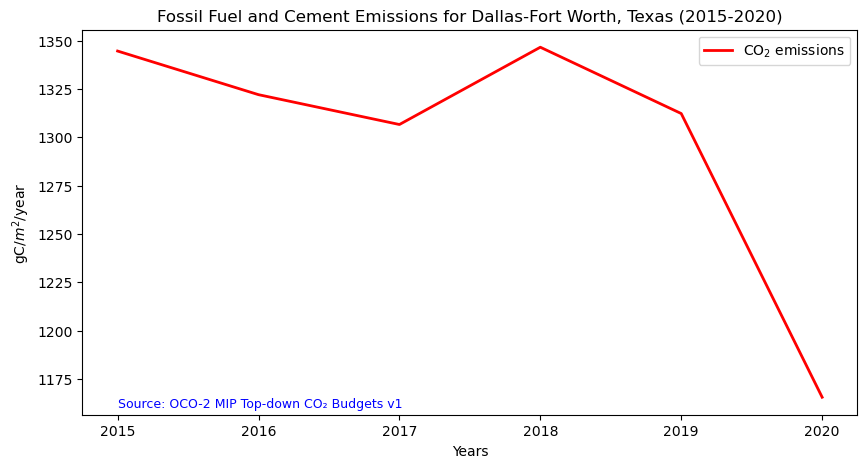

In [44]:
# Figure size: 10 is width, 5 is height
fig = plt.figure(figsize=(10,5))

# Sort our df by datetime
df = df.sort_values(by="datetime")

# Change 'which_stat' below if you would rather look at a different statistic, like minimum or mean.
which_stat = "mean"

plt.plot(
    [d[0:4] for d in df["datetime"]], # X-axis: sorted datetime
    df[which_stat], # Y-axis: maximum CO₂ emission
    color="red", # Line color
    linestyle="-", # Line style
    linewidth=2, # Line width
    label="CO$_2$ emissions", # Legend label
)

# Display legend
plt.legend()

# Insert label for the X-axis
plt.xlabel("Years")

# Insert label for the Y-axis
plt.ylabel("gC/$m^2$/year")

# Insert title for the plot
plt.title(f"{items[0].assets[asset_name].title} for {aoi_name} (2015-2020)")

# Add data citation
plt.text(
    min([d[0:4] for d in df["datetime"]]),           # X-coordinate of the text 
    df[which_stat].min(),                  # Y-coordinate of the text 
    # Text to be displayed
    f"Source: {collection.title}",                  
    fontsize=9,                             # Font size
    horizontalalignment="left",              # Horizontal alignment
    verticalalignment="top",                 # Vertical alignment
    color="blue",                            # Text color
)

# Plot the time series
plt.show()

## Summary

In this notebook we have successfully explored, analyzed, and visualized the STAC collection for OCO-2 MIP Top-Down CO₂ Budgets.

1.  Install and import the necessary libraries
2.  Fetch the collection from STAC collections using the appropriate endpoints
3.  Count the number of existing granules within the collection
4.  Visualizing CO₂ Emissions for two distinctive months/years
5.  Generate zonal statistics for a specified region
6.  Generate a time-series graph


If you have any questions regarding this user notebook, please contact us using the [feedback form](https://docs.google.com/forms/d/e/1FAIpQLSeVWCrnca08Gt_qoWYjTo6gnj1BEGL4NCUC9VEiQnXA02gzVQ/viewform).